In [38]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io.wavfile import read as read_wav
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix


current_dir = Path.cwd() 
path = current_dir /'set_b/'
files = os.listdir(path) 

In [39]:
#sample frequency

def check(lst):
  
    ele = lst[0]
    chk = True
      
    for item in lst:
        if ele != item:
            chk = False
            break;
              
    if (chk == True): print("Equal")
    else: print("Not equal")            
  
    
fss = []
signals = []
for file in files:
    fs, signal = read_wav(path/file)
    fss.append(fs)
    signals.append(signal)
      
check(fss)


Equal


In [40]:
#mfcc
mfccs = []
labels=[]
sig_len=[]

for file in files: 
    if file.startswith('normal'):
        x, fs = librosa.load(path/file)
        mfcc_13_coeffs = librosa.feature.mfcc(x, sr=fs, n_mfcc=13)
        mfccs.append(mfcc_13_coeffs)
        sig_len.append(np.shape(mfcc_13_coeffs)[1])
        labels.append(0)
    if file.startswith('extrastole'):
        x, fs = librosa.load(path/file)
        mfcc_13_coeffs = librosa.feature.mfcc(x, sr=fs, n_mfcc=13)
        mfccs.append(mfcc_13_coeffs)
        sig_len.append(np.shape(mfcc_13_coeffs)[1])
        labels.append(1) 
    if file.startswith('murmur'):
        x, fs = librosa.load(path/file)
        mfcc_13_coeffs = librosa.feature.mfcc(x, sr=fs, n_mfcc=13)
        mfccs.append(mfcc_13_coeffs)
        sig_len.append(np.shape(mfcc_13_coeffs)[1])
        labels.append(2)
        
trunc_mfccs = []
for item in mfccs:
    item = item[:, :np.min(sig_len)]
    trunc_mfccs.append(item)
mfccs = np.asarray(trunc_mfccs)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(mfccs, labels, test_size=0.2, random_state=42, stratify=labels)
X_train = X_train.reshape(np.shape(X_train)[0],-1) #obcinanie wymiaru
X_train.shape
X_test = X_test.reshape(np.shape(X_test)[0],-1)

In [42]:
X_train=np.array(X_train)
std_clf=StandardScaler()
std_clf.fit(X_train)

StandardScaler()

In [43]:
#PCA 
pca = PCA(n_components=9) #bierzemy dziewięć składowych, ponieważ dają nam one >80% istotności
principal_components_train = pca.fit_transform(X_train)
principal_components_test = pca.transform(X_test)
y_train=np.asarray(y_train)

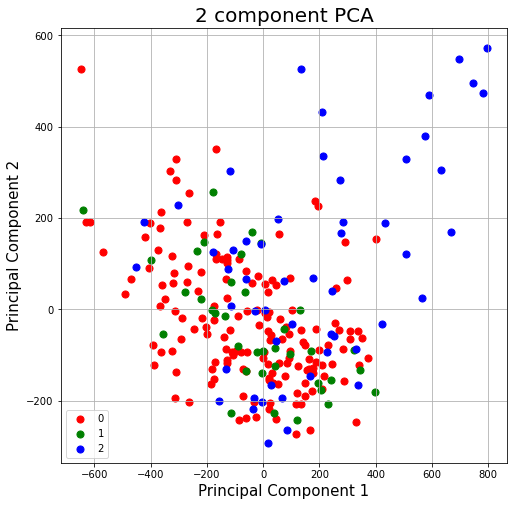

In [44]:
#visualization of 2 components PCA
pca_df = pd.DataFrame(data = (np.hstack((principal_components_train[:,:2], y_train[:, np.newaxis]))),
             columns = ['PC1', 'PC2', 'target numerical'])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['target numerical'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'PC1']
               , pca_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [45]:
#optimal number of components = 9
pca.explained_variance_ratio_

array([0.40214378, 0.17043445, 0.0560741 , 0.04287679, 0.04154952,
       0.03574865, 0.02764458, 0.02237974, 0.01786308], dtype=float32)

In [46]:
pca_df 

,PC1,PC2,target numerical
0,5.810142,56.404316,0.0
1,-60.076065,-135.215698,0.0
2,-6.420180,145.604538,1.0
3,217.012405,-144.797226,0.0
4,-172.581268,-115.581161,0.0
...,...,...,...
244,-262.761475,254.958176,0.0
245,290.301880,148.588547,0.0
246,-30.176506,-3.853209,2.0
247,244.880417,41.284988,2.0


In [55]:
#KNeighbours
clf = KNeighborsClassifier(n_neighbors=3) 
clf.fit(principal_components_train, y_train)
preds = clf.predict(principal_components_test)

print(preds)
print(confusion_matrix(y_test, preds))

acc = accuracy_score(y_test, preds)
recall = recall_score(y_test, preds,average='weighted')
prec = precision_score(y_test, preds,average='weighted', zero_division=1)
f1 = f1_score(y_test, preds,average='weighted')
print(acc, recall, prec, f1)

[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
[[41  0  0]
 [ 9  0  0]
 [ 7  0  6]]
0.746031746031746 0.746031746031746 0.8173210804789752 0.6748674407106201


In [56]:
#SVC 
clf = svm.SVC(C=0.9,kernel='rbf',gamma='scale') 
clf.fit(principal_components_train, y_train)

preds_svm = clf.predict(principal_components_test)
confusion_matrix(y_test, preds_svm)

print(preds_svm)
print(confusion_matrix(y_test, preds_svm))

#metryki
acc_svm = accuracy_score(y_test, preds_svm)
recall_svm = recall_score(y_test, preds_svm,average='weighted')
prec_svm = precision_score(y_test, preds_svm,average='weighted', zero_division=1)
f1_svm = f1_score(y_test, preds_svm,average='weighted')
print(acc_svm, recall_svm, prec_svm, f1_svm)

[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
[[41  0  0]
 [ 9  0  0]
 [ 7  0  6]]
0.746031746031746 0.746031746031746 0.8173210804789752 0.6748674407106201


In [57]:
#Random Forrest

model = RandomForestClassifier(n_estimators=100)
model.fit(principal_components_train, y_train) 
preds_rf = model.predict(principal_components_test)

print(preds_rf)
print(confusion_matrix(y_test, preds_rf))

#metryki
acc_rf = accuracy_score(y_test, preds_rf)
recall_rf = recall_score(y_test, preds_rf,average='weighted')
prec_rf = precision_score(y_test, preds_rf,average='weighted', zero_division=1)
f1_rf = f1_score(y_test, preds_rf,average='weighted')
print(acc_rf, recall_rf, prec_rf, f1_rf)

[0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[40  0  1]
 [ 9  0  0]
 [ 7  0  6]]
0.7301587301587301 0.7301587301587301 0.7845804988662132 0.6605465553919162
